# HW2 - Generative Models

In [18]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex
from scipy import stats

## Reading the data

In [19]:
f=open('README.md')
x1=[]
x2=[]
check=0
for line in f:
    if check==1 and not line.startswith('`'):
        x=line.split()
        x[0]=float(x[0])
        x[1]=float(x[1])
        x1.append(x[0])
        x2.append(x[1])
    if line.startswith('x1'):
        check=1

## 1. Visualizing the data

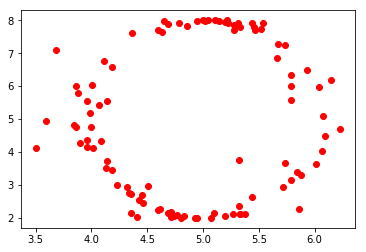

In [20]:
plt.plot(x1,x2,'ro')
plt.show()

## 2. My generative model

$$ U=N(\pi,2\pi) $$
$$ y_1=\sqrt{2}\sigma_1 \times cos(U)+ mean_1 +\epsilon_1 $$
$$ \epsilon_1=N(0,0.10) $$
$$ y_2=\sqrt{2}\sigma_2 \times sin(U)+ mean_2 +\epsilon_2 $$
$$ \epsilon_2=N(0,0.01) $$

### 2.1. Explanation of the generative model

The obvious circle-like shape of the data suggests a model of a circle (or an ellipse). For this purpose, I will use a normally distributed variable, namely U, with a mean of $\pi$ and a variance of $2\pi$. For $y_1$, the cosine of the values of U will be taken. This procedure halves the variance, so the standard deviation $\sigma_1$ is multiplied by $\sqrt{2}$ (the same situation (and correction) applies for $y_2$). Then, the mean of the given dataset is added separately to both dimensions $y_1$ and $y_2$. Finally an error term is added to both models.

## 3. Implementation & sampling from data

To decide the values of $\sigma_1, \sigma_2, mean_1,$ and $mean_2$ the data is inspected. The values found are as follows:<br>
$mean_1=4.89903$<br>
$mean_2=4.85242$<br>
$\sigma_1^2=0.4935174491$<br>
$\sigma_2^2=5.0603002436$

After these values and visual inspection of models with different mean and variance values, the values $mean_1$ and $mean_2$ are decided to be taken as 5, which is very close to the mean values of the given data. The value $\sigma_1^2$ is taken as 0.5, similar to the value from the data. However, after visual inspection the value $\sigma_2^2$ is decided to be taken as 4.5, rather than 5 which is closer to the value that the data suggests. This has been done because it is believed that the value taken fits better to the data than the one coming from the data. Of course, a more scientific way could have been followed to decide on the value of $\sigma_2$, such as conducting some goodness of fit test for both values and seeing which fits better.

In [27]:
mean1=np.mean(x1)
mean2=np.mean(x2)
var1=np.var(x1)
var2=np.var(x2)
print mean1, mean2, var1, var2
U=np.random.normal(np.pi,2*np.pi,size=100)
y1=np.sqrt(1)*np.cos(U)+5+np.random.normal(0,0.10,size=100)
y2=np.sqrt(9)*np.sin(U)+5+np.random.normal(0,0.01,size=100)

4.89903 4.85242 0.4935174491 5.0603002436


## 4. Visualization of synthetic data

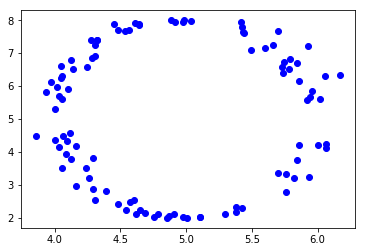

In [22]:
plt.plot(y1,y2,'ro',color='blue')
plt.show()

### 4.1. Synthetic data vs given dataset

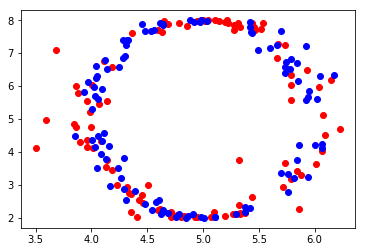

In [23]:
plt.plot(x1,x2,'ro')
plt.plot(y1,y2,'ro',color='blue')
plt.show()

## 5. Comparison of two datasets

The similarity of the two datasets can be assessed using both visual inspection and quantitative tools.

### 5.1. Qualitative comparison

First, the simlarity of two datasets can be checked visually, to see if they have similar means, variances, shapes, patterns, and so on. The first thing that can be observed in the given dataset is its circle-like shape. This shape is approximated with the generated dataset. The second thing realized is the variance existing on x-axis, which is much greater than the variance on y-axis. The generated dataset also has a simialr feature (due to the added error on x-axis in the generative model, which is 10 times more than the error added in the generative model in the y-axis). Overall, it can be said that the two datasets look similar after the visual inspection.

### 5.2. Quantitative comparison

We can use the two-sample Kolmogorov-Smirnov(2sKS) test to see if the given data and the sythetic data created from the generative model are similar. This test will be conducted in two steps, two separate 2sKS tests since the data is two dimensional.

In [24]:
stats.ks_2samp(x1, y1)

Ks_2sampResult(statistic=0.11000000000000001, pvalue=0.55601716622975661)

In [25]:
stats.ks_2samp(x2, y2)

Ks_2sampResult(statistic=0.13, pvalue=0.34388571222170117)

The results for the 2sKS tests show that there is no significant difference between the two datasets, i.e. the null hypothesis that two samples are drawn from the same distribution cannot be rejected. (In this test, when the statistic is lower than the p-value, this means the difference is not significant between the two samples.)

Alternatively, one can also use t-test and F-test to see if the means and variances of two datasets are significantly different or not. Also, the SSE (or MSE) of the model (in the form of $y=f(x)$) can be checked using the provided data. 